In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import peptide_forest


In [2]:
# tmt_translation = {
#     "62": "126",
#     "63": "127L",
#     "64": "127H",
#     "65": "128L",
#     "66": "128H",
#     "67": "129L",
#     "68": "129H",
#     "69": "130L",
#     "70": "130H",
#     "71": "131L",
# }
tmts = ['126', '127L', '127H', '128L', '128H', '129L', '129H', '130L', '130H', '131L']

expected_values = {
    "126": (0, 1),
    "127L": (1, 1),
    "127H": (1, 0),
    "128L": (0.5, 1),
    "128H": (0.5, 0),
    "129L": (0.2, 1),
    "129H": (0.2, 0),
    "130L": (0.1, 1),
    "130H": (0.1, 0),
    "131L": (1, 1),
}

# quant_df = pd.read_csv(
#     "../data/_pep_quant_data/04854_F1_R8_P0109699E13_pep_quant_data.txt",
#     sep="\t",
#     lineterminator="\n",
# )
quant_df = pd.read_csv("../data/_quant_new/04854_F1_R8_P0109699E13_TMT10_quant_pots.csv", index_col=0)

final_df = pd.read_csv("../output.csv")

In [3]:
#quant_df["MSMS_ID"] = quant_df["MSMS_ID"].str.lstrip("F0")
quant_df["MSMS_ID"] = quant_df["spectrum_id"]
unique_spec_ids = final_df["Spectrum ID"].drop_duplicates()
ma_df = pd.DataFrame(index=unique_spec_ids)

q_val_cuts = sorted([float(f"1e-{j}") for j in np.arange(4, 1, -1)]) + [1e-1]

final_df = peptide_forest.results.calc_all_final_q_vals(
    df=final_df, frac_tp=0.9, top_psm_only=False, initial_engine=None
)

all_eng = [
    c.split("Score_processed_")[1] for c in final_df.columns if "Score_processed" in c
]
for cut in q_val_cuts:
    for eng in all_eng:
        eng_per_q_col = f"top_target_{eng}_at_{cut}"
        target_col = f"top_target_{eng}"
        marked_targets = peptide_forest.results.mark_top_targets(
            df=final_df, q_cut=cut
        )[[target_col, "Spectrum ID"]]
        marked_targets = marked_targets[marked_targets[target_col]]["Spectrum ID"]
        ma_df[eng_per_q_col] = False
        ma_df.loc[marked_targets, eng_per_q_col] = True


In [4]:
# Add species column
inds = ma_df.index.to_list()
spec_species = final_df.loc[
    final_df["Spectrum ID"].drop_duplicates().isin(inds).index,
    ["Protein ID", "Spectrum ID"],
]
ma_df.loc[spec_species["Spectrum ID"].to_list(), "species"] = spec_species[
    "Protein ID"
].to_list()
ma_df.loc[
    ma_df["species"].str.contains("OS=Escherichia coli")
    & ~ma_df["species"].str.contains("OS=Homo sapiens"),
    "species",
] = "E_coli"
ma_df.loc[
    ~ma_df["species"].str.contains("OS=Escherichia coli")
    & ma_df["species"].str.contains("OS=Homo sapiens"),
    "species",
] = "H_sapiens"
ma_df.loc[~ma_df["species"].str.contains("E_coli|H_sapiens")] = "Other"

In [5]:
# Drop rows that never appear as top target
top_target_cols = [c for c in ma_df.columns if "top_target" in c]
ma_df[top_target_cols] = ma_df[top_target_cols].astype(bool)
ma_df = ma_df[ma_df[top_target_cols].any(axis=1)]

In [6]:
# Generate all and any engines
for cut in q_val_cuts:
    eng_cols_per_cut = [f"top_target_{engine}_at_{cut}" for engine in all_eng]

    ma_df[f"top_target_any_engine_at_{cut}"] = False
    ma_df.loc[
        ma_df[eng_cols_per_cut].any(axis=1), f"top_target_any_engine_at_{cut}"
    ] = True

    ma_df[f"top_target_all_engines_at_{cut}"] = False
    ma_df.loc[
        ma_df[eng_cols_per_cut].all(axis=1), f"top_target_all_engines_at_{cut}"
    ] = True

In [7]:
all_eng = all_eng + ["all_engines", "any_engine"]

# for label, tmt in tmt_translation.items():
#     values = quant_df[quant_df["ISOTOPELABEL_ID"] == int(label)][
#         ["MSMS_ID", "QUANTVALUE"]
#     ].astype({"MSMS_ID": "int64", "QUANTVALUE": "float64"})
#     # Remove missing spectra
#     values = values[values["MSMS_ID"].isin(ma_df.index)]
#     ma_df.loc[values["MSMS_ID"], tmt] = values["QUANTVALUE"].to_list()

for t in tmts:
    values = quant_df[quant_df["label"] == t][["MSMS_ID", "quant_value"]].astype({"MSMS_ID": "int64", "quant_value": "float64"})
    # Remove missing spectra
    values = values[values["MSMS_ID"].isin(ma_df.index)]
    ma_df.loc[values["MSMS_ID"], t] = values["quant_value"].to_list()


In [8]:
# Remove all SpecIDs where quant value is 0 in a mixed column
mixed_cols = ["127L", "128L", "129L", "130L", "131L"]
ma_df = ma_df[~ma_df[mixed_cols].any(axis=1) == 0]

# Remove all nan rows
ma_df = ma_df[~ma_df[tmts].isna().all(axis=1)]

In [9]:
quotients = list(itertools.combinations(tmts, 2))

# [TRISTAN] temp
all_eng = ["all_engines", "any_engine", "RF-reg", "omssa_2_1_9"]

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

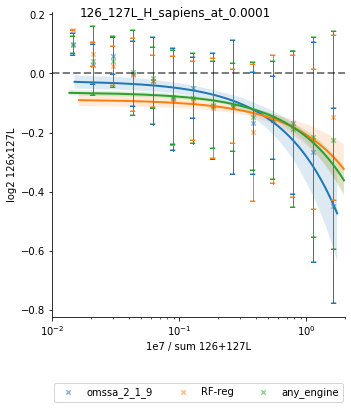

<Figure size 432x288 with 0 Axes>

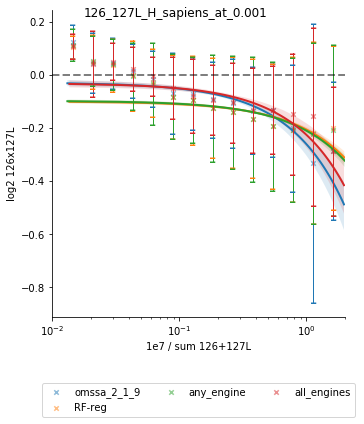

<Figure size 432x288 with 0 Axes>

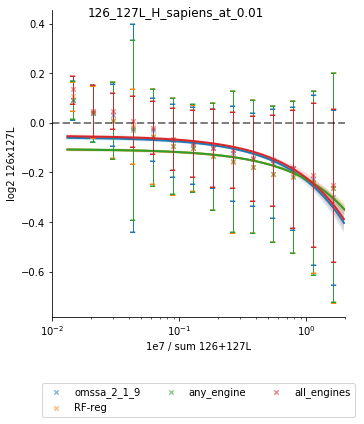

<Figure size 432x288 with 0 Axes>

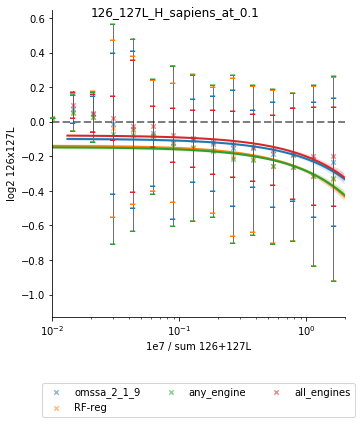

<Figure size 432x288 with 0 Axes>

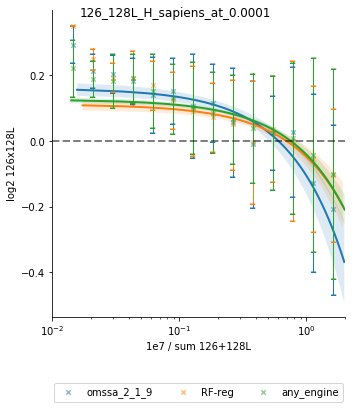

<Figure size 432x288 with 0 Axes>

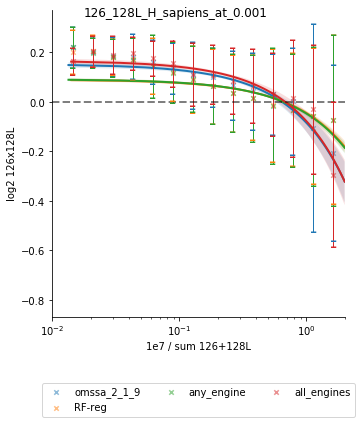

<Figure size 432x288 with 0 Axes>

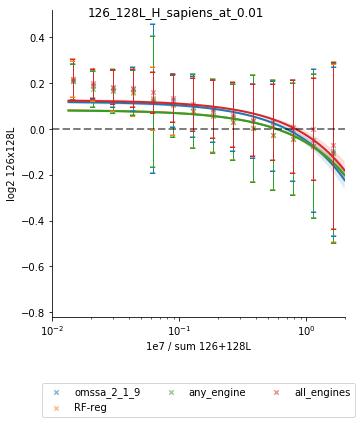

In [10]:
for ratio in quotients:
    for species in ["H_sapiens", "E_coli"]:
        if (
            species == "E_coli"
            and expected_values[ratio[1]][0] != 0
            and expected_values[ratio[0]][0] != 0
        ):
            exp_y = np.log2(expected_values[ratio[0]][0] / expected_values[ratio[1]][0])
        elif (
            species == "H_sapiens"
            and expected_values[ratio[1]][1] != 0
            and expected_values[ratio[0]][1] != 0
        ):
            exp_y = np.log2(expected_values[ratio[0]][1] / expected_values[ratio[1]][1])
        else:
            continue
        species_df = ma_df[ma_df["species"] == species]
        for cut in q_val_cuts:
            plt.figure()
            cols_oi = [f"top_target_{eng}_at_{cut}" for eng in all_eng]
            df_plot = pd.DataFrame()

            for c in cols_oi:
                if species_df[c].sum() <= 1:
                    continue

                sub_df = species_df[species_df[c]]
                # Get around RuntimeWarning for log2
                sub_df = sub_df.replace(to_replace=0, value=1e-308)
                df_eng = pd.DataFrame()
                df_eng["x_axis"] = 1e7 / (sub_df[ratio[0]] + sub_df[ratio[1]])
                df_eng["y_axis"] = np.log2(sub_df[ratio[0]] / sub_df[ratio[1]])
                df_eng["engine"] = c.split("top_target_")[1].split("_at")[0]
                df_eng = df_eng[df_eng["x_axis"] < 2]

                if len(df_plot) == 0:
                    df_plot = df_eng
                else:
                    df_plot = pd.concat([df_eng, df_plot])

            plot = sns.lmplot(
                x="x_axis",
                y="y_axis",
                hue="engine",
                data=df_plot,
                x_bins=np.logspace(-2, 1, 20),
                scatter_kws={"s": 20, "alpha": 0.5},
                line_kws={"lw": 2},
                x_ci="sd",
                markers="x",
                legend=False,
            )
            err_lines = [
                l
                for l in plot.ax.lines
                if len(l.get_xdata()) == 2 and l.get_xdata()[0] == l.get_xdata()[1]
            ]
            for el in err_lines:
                el.set_linewidth(1)
                x_caps = el.get_xdata()[0]
                y_caps = el.get_ydata()
                position = {
                    "ha": "center",
                    "va": "center",
                    "size": 20,
                    "color": el.get_color(),
                }
                cap_lower = plot.ax.annotate("-", xy=(x_caps, y_caps[0]), **position)
                cap_upper = plot.ax.annotate("-", xy=(x_caps, y_caps[1]), **position)

            legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)
            plot.ax.axhline(
                exp_y, color="black", linestyle="--", linewidth=2, alpha=0.5
            )
            plot.ax.set_xlim(0.01, 2)
            plot.set_axis_labels(
                f"1e7 / sum {ratio[0]}+{ratio[1]}", f"log2 {ratio[0]}x{ratio[1]}"
            )
            plot.set(xscale="log")
            plot.fig.suptitle(f"{ratio[0]}_{ratio[1]}_{species}_at_{cut}")
            plt.savefig(
                f"../plots/ma/{ratio}_{species}_at_{cut}.png",
                bbox_extra_artists=[legend],
                bbox_inches="tight",
                dpi=600,
            )